In [84]:
# load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import re
import warnings
warnings.filterwarnings('ignore')




In [85]:
# Define Spotify colors and set default style
SPOTIFY_GREEN = '#1DB954'
SPOTIFY_BLACK = '#191414'
SPOTIFY_WHITE = '#FFFFFF'

# Set default style with Spotify colors
plt.rcParams['figure.facecolor'] = SPOTIFY_BLACK
plt.rcParams['axes.facecolor'] = SPOTIFY_BLACK
plt.rcParams['text.color'] = SPOTIFY_WHITE
plt.rcParams['axes.labelcolor'] = SPOTIFY_WHITE
plt.rcParams['xtick.color'] = SPOTIFY_WHITE
plt.rcParams['ytick.color'] = SPOTIFY_WHITE

In [86]:
# here we will load the data
data = pd.read_csv('/Users/danielharrod/spotify_sentiment/data/spotify_reviews.csv')

data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,437314fe-1b1d-4352-abea-12fec30fce58,Rajib Das,It's good,4,0,NaN,2024-05-09 16:28:13,NaN
1,4933ad2c-c70a-4a84-957d-d405439b2e0f,Mihaela Claudia Neagu,"I love this app so much, I've been using Spoti...",5,0,8.9.38.494,2024-05-09 16:27:18,8.9.38.494
2,1ab275fb-59bf-42c7-88ef-b85901f0445e,JONATHAN GRACIA,Perfect,5,0,8.9.36.616,2024-05-09 16:27:03,8.9.36.616
3,b38406eb-7b11-4ceb-a45c-d7f28fb5d382,Cam Rempel,Best all around music streaming app I have use...,5,0,8.9.38.494,2024-05-09 16:26:19,8.9.38.494
4,7be7999d-4cb6-47b9-8414-d7bdaa9df578,Your clowness (Her Clowness),Are y'all fr gatekeeping the play button on so...,1,0,8.9.38.494,2024-05-09 16:26:14,8.9.38.494


In [87]:
# see how many nan values we have
data.isna().sum()

reviewId                   0
userName                   4
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    5768
at                         0
appVersion              5768
dtype: int64

In [88]:
def clean_text(text):
    """
    Clean text data by removing special characters and converting to lowercase
    """
    if isinstance(text, str):
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Convert to lowercase
        text = text.lower().strip()
        
        return text
    return ''

In [89]:
# Preprocess the data
try:
    # Convert date
    data['at'] = pd.to_datetime(data['at'])
    
    # Clean the content column
    data['clean_content'] = data['content'].apply(clean_text)
    
    # Display sample of cleaned text
    print("Sample of original and cleaned text:")
    sample_data = pd.DataFrame({
        'Original': data['content'].head(),
        'Cleaned': data['clean_content'].head()
    })
    print(sample_data)
    
except KeyError as e:
    print(f"Error: Column not found - {e}")
    print("Available columns:", data.columns.tolist())
except Exception as e:
    print(f"Error during preprocessing: {e}")

Sample of original and cleaned text:
                                            Original  \
0                                          It's good   
1  I love this app so much, I've been using Spoti...   
2                                            Perfect   
3  Best all around music streaming app I have use...   
4  Are y'all fr gatekeeping the play button on so...   

                                             Cleaned  
0                                           its good  
1  i love this app so much ive been using spotify...  
2                                            perfect  
3  best all around music streaming app i have use...  
4   are yall fr gatekeeping the play button on songs  


### Sentiment Analysis

In [90]:
def get_sentiment(text):
    """
    Calculate sentiment polarity score using TextBlob
    """
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    return 0

In [91]:
#Perform sentiment analysis
try:
    data['sentiment_score'] = data['clean_content'].apply(get_sentiment)
    data['sentiment_category'] = data['sentiment_score'].apply(
        lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
    )
    
    # Display sentiment distribution
    print("\nSentiment Distribution:")
    print(data['sentiment_category'].value_counts())
    print("\nSentiment Score Statistics:")
    print(data['sentiment_score'].describe())
    
except KeyError as e:
    print(f"Error: Column not found - {e}")
except Exception as e:
    print(f"Error during sentiment analysis: {e}")



Sentiment Distribution:
sentiment_category
Positive    52520
Negative    28131
Neutral      3514
Name: count, dtype: int64

Sentiment Score Statistics:
count    84165.000000
mean         0.085906
std          0.265778
min         -1.000000
25%         -0.060000
50%          0.075000
75%          0.237500
max          1.000000
Name: sentiment_score, dtype: float64


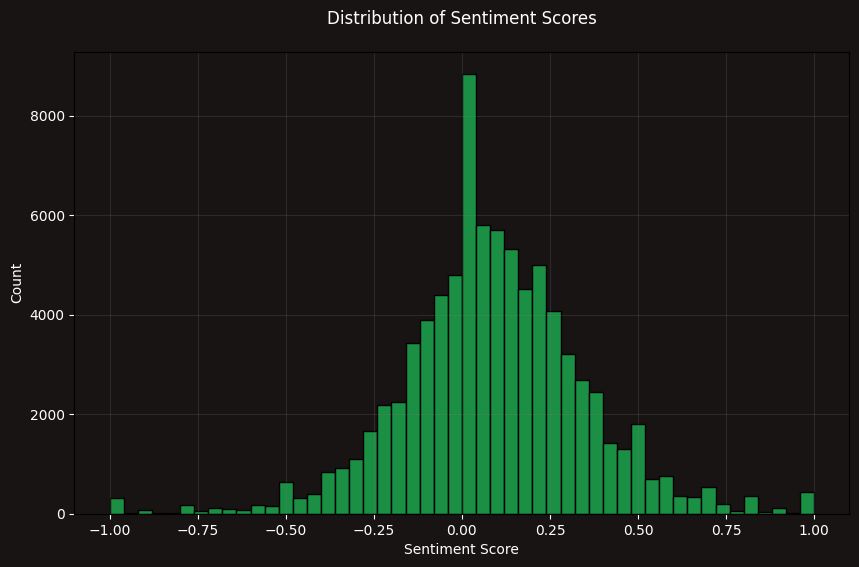

In [92]:
# 1. Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='sentiment_score', bins=50, color=SPOTIFY_GREEN)
plt.title('Distribution of Sentiment Scores', color=SPOTIFY_WHITE, pad=20)
plt.xlabel('Sentiment Score', color=SPOTIFY_WHITE)
plt.ylabel('Count', color=SPOTIFY_WHITE)
plt.grid(True, color='gray', alpha=0.2)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/sentiment_distribution.png', bbox_inches='tight', facecolor=SPOTIFY_BLACK)

plt.show()



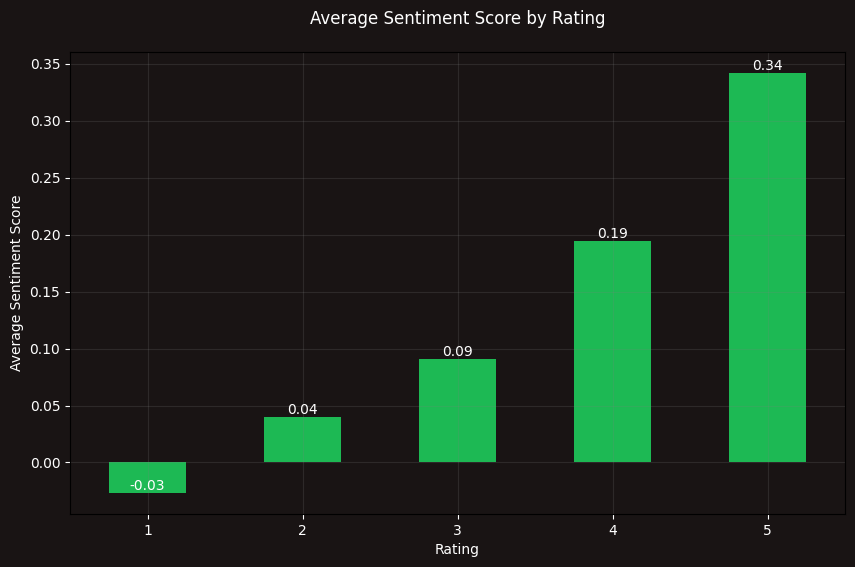

In [115]:
# 2. Average Sentiment by Rating
plt.figure(figsize=(10, 6))
ax = data.groupby('score')['sentiment_score'].mean().plot(
    kind='bar',
    color=SPOTIFY_GREEN
)
plt.title('Average Sentiment Score by Rating', color=SPOTIFY_WHITE, pad=20)
plt.xlabel('Rating', color=SPOTIFY_WHITE)
plt.ylabel('Average Sentiment Score', color=SPOTIFY_WHITE)
plt.grid(True, color='gray', alpha=0.2)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/average_sentiment_score.png', bbox_inches='tight', facecolor=SPOTIFY_BLACK)

plt.xticks(rotation=0)

# Add value labels on top of bars
for i, v in enumerate(data.groupby('score')['sentiment_score'].mean()):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', color=SPOTIFY_WHITE)
plt.show()



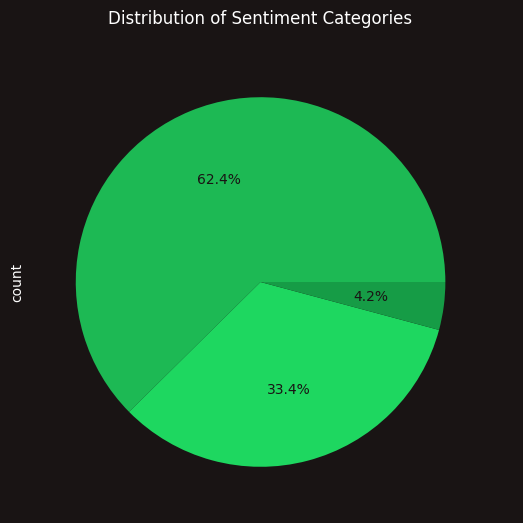

In [94]:
# 3. Sentiment Categories Distribution
plt.figure(figsize=(10, 6))
colors = [SPOTIFY_GREEN, '#1ed760', '#169c46']  # Different shades of Spotify green
data['sentiment_category'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=colors,
    textprops={'color': SPOTIFY_BLACK}
)
plt.title('Distribution of Sentiment Categories', color=SPOTIFY_WHITE, pad=20)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/sentiment_category_distribution.png', facecolor=SPOTIFY_BLACK, bbox_inches='tight')
plt.show()





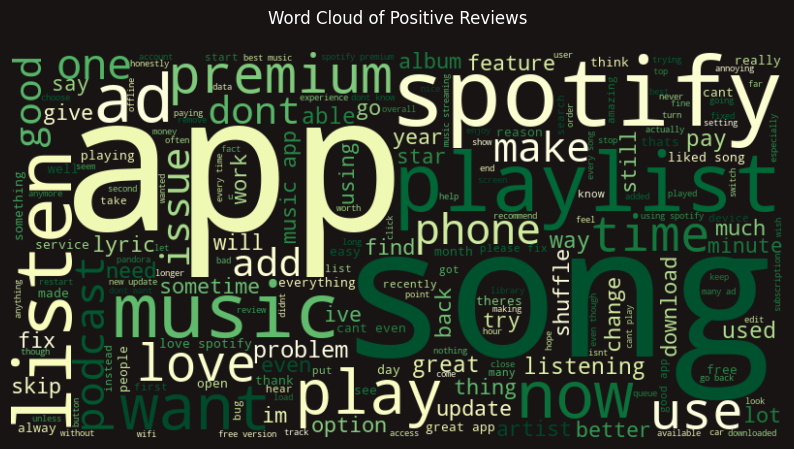

In [95]:
# Generate and display word cloud
text = ' '.join(data[data['sentiment_score'] > 0]['clean_content'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color=SPOTIFY_BLACK,
    colormap='YlGn',
    contour_color=SPOTIFY_GREEN,
    contour_width=3
).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews', color=SPOTIFY_WHITE, pad=20)
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/positive_reviews_wordcloud.png', bbox_inches='tight', facecolor=SPOTIFY_BLACK)
plt.show()





In [96]:
# Analyze common words
vectorizer = CountVectorizer(max_features=10, stop_words='english')

# Positive reviews analysis
positive_text = data[data['sentiment_score'] > 0]['clean_content']
positive_matrix = vectorizer.fit_transform(positive_text)
positive_words = pd.DataFrame(
    positive_matrix.sum(axis=0).T,
    index=vectorizer.get_feature_names_out(),
    columns=['count']
).sort_values('count', ascending=False)


In [97]:
# Negative reviews analysis
negative_text = data[data['sentiment_score'] < 0]['clean_content']
vectorizer = CountVectorizer(max_features=10, stop_words='english')
negative_matrix = vectorizer.fit_transform(negative_text)
negative_words = pd.DataFrame(
    negative_matrix.sum(axis=0).T,
    index=vectorizer.get_feature_names_out(),
    columns=['count']
).sort_values('count', ascending=False)


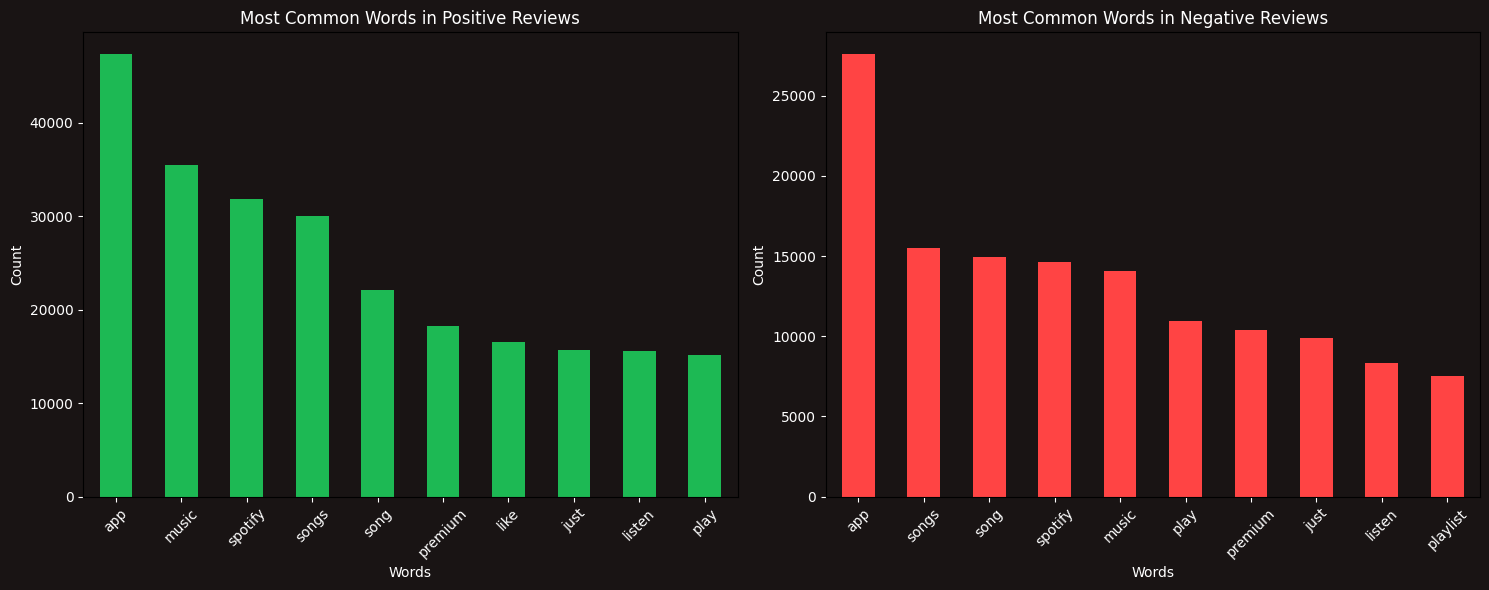

In [98]:
# Visualize common words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor(SPOTIFY_BLACK)

# Positive words plot
positive_words['count'].plot(kind='bar', ax=ax1, color=SPOTIFY_GREEN)
ax1.set_title('Most Common Words in Positive Reviews', color=SPOTIFY_WHITE)
ax1.set_xlabel('Words', color=SPOTIFY_WHITE)
ax1.set_ylabel('Count', color=SPOTIFY_WHITE)
ax1.tick_params(axis='x', rotation=45)

# Negative words plot
negative_words['count'].plot(kind='bar', ax=ax2, color='#ff4444')
ax2.set_title('Most Common Words in Negative Reviews', color=SPOTIFY_WHITE)
ax2.set_xlabel('Words', color=SPOTIFY_WHITE)
ax2.set_ylabel('Count', color=SPOTIFY_WHITE)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/Users/danielharrod/spotify_sentiment/figures/common_words.png', facecolor=SPOTIFY_BLACK, bbox_inches='tight')
plt.show()



In [99]:
print("\nSummary Statistics:")
print(f"Total number of reviews: {len(data)}")
print(f"Average sentiment score: {data['sentiment_score'].mean():.3f} out of 1.")
print("\nMost common words in positive reviews:")
print(positive_words.head())
print("\nMost common words in negative reviews:")
print(negative_words.head())


Summary Statistics:
Total number of reviews: 84165
Average sentiment score: 0.086 out of 1.

Most common words in positive reviews:
         count
app      47305
music    35464
spotify  31877
songs    30002
song     22073

Most common words in negative reviews:
         count
app      27579
songs    15495
song     14958
spotify  14615
music    14075


In [214]:
import openai
import os
from dotenv import load_dotenv
import time
from tqdm import tqdm

# Load environment variables from the .env file
load_dotenv()

# Get the API key from the .env file
openai.api_key = os.getenv("OPENAI_API_KEY")

# Verify API Key Loading
if not openai.api_key:
    print("Failed to load API key. Check your .env file.")
else:
    print("API Key loaded successfully!")


API Key loaded successfully!


In [246]:
import openai
import os
from dotenv import load_dotenv
import time
from tqdm import tqdm

# Load environment variables from the .env file
load_dotenv()

# Get the API key from the .env file
openai.api_key = os.getenv("OPENAI_API_KEY")

# Verify API Key Loading
if not openai.api_key:
    print("Failed to load API key. Check your .env file.")
else:
    print("API Key loaded successfully!")

def get_summary_from_gpt(reviews, context):
 
    try:
        # Combine reviews into a single string with line breaks
        reviews_text = "\n".join(reviews)
        
        # Create the prompt
        prompt = f"""
        As a data analyst, analyze these Spotify app reviews {context}:

        {reviews_text}

        Please provide a concise summary that includes:
        1. Main themes and patterns
        2. Common praise points
        3. Common complaints or suggestions
        4. Notable quotes or specific feedback
        5. Overall sentiment and user satisfaction

        Format the response in markdown with appropriate headers.
        """
        
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a skilled data analyst specializing in user feedback analysis."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=1000,
            temperature=0.7
        )
        
        summary = response['choices'][0]['message']['content']
        return summary
    
    except Exception as e:
        print(f"Error in getting summary: {e}")
        


API Key loaded successfully!


In [247]:
def summarize_by_rating(data, sample_size=50):  # Reduced sample size for testing
    """
    Summarize reviews grouped by rating
    """
    summaries = {}
    
    for rating in sorted(data['score'].unique()):
        print(f"\nProcessing rating {rating}/5...")
        
        # Get reviews for this rating
        rating_reviews = data[data['score'] == rating]['content'].dropna()
        
        # Sample reviews if there are too many
        if len(rating_reviews) > sample_size:
            rating_reviews = rating_reviews.sample(sample_size, random_state=42)
        
        context = f"for {rating}/5 star ratings"
        summary = get_summary_from_gpt(rating_reviews.tolist(), context)  # Convert to list
        
        if summary:
            summaries[rating] = summary
        
        # Sleep to respect API rate limits
        time.sleep(2)
    
    return summaries

In [248]:
def summarize_by_sentiment(data, sample_size=50):  # Reduced sample size for testing
   
    summaries = {}
    
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        print(f"\nProcessing {sentiment} reviews...")
        
        # Get reviews for this sentiment
        sentiment_reviews = data[data['sentiment_category'] == sentiment]['content'].dropna()
        
        # Sample reviews if there are too many
        if len(sentiment_reviews) > sample_size:
            sentiment_reviews = sentiment_reviews.sample(sample_size, random_state=42)
        
        context = f"with {sentiment.lower()} sentiment"
        summary = get_summary_from_gpt(sentiment_reviews.tolist(), context)  # Convert to list
        
        if summary:
            summaries[sentiment] = summary
        
        # Sleep to respect API rate limits
        time.sleep(2)
    
    return summaries

In [ ]:
# Get summaries for each rating
print("Generating summaries by rating...")
rating_summaries = summarize_by_rating(data)

# Save summaries to markdown file
with open('figures/rating_summaries.md', 'w', encoding='utf-8') as f:
    f.write("# Spotify Reviews Analysis by Rating\n\n")
    for rating, summary in rating_summaries.items():
        f.write(f"## {rating} Star Reviews\n")
        f.write(summary)
        f.write("\n\n")


# Get summaries for each sentiment category
print("Generating summaries by sentiment...")
sentiment_summaries = summarize_by_sentiment(data)

# Save summaries to markdown file
with open('figures/sentiment_summaries.md', 'w', encoding='utf-8') as f:
    f.write("# Spotify Reviews Analysis by Sentiment\n\n")
    for sentiment, summary in sentiment_summaries.items():
        f.write(f"## {sentiment} Reviews\n")
        f.write(summary)
        f.write("\n\n")



# Display an example of 5-star reviews summary
print("Example: Summary of 5-star reviews")
print("-" * 50)
print(rating_summaries.get(5, "No summary available for 5-star reviews"))